### **Data Analysis**

In [1]:
!pip install statsmodels
!pip install scikit-posthocs
!pip install cliffs_delta
!pip install ruptures

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm 
from statsmodels.formula.api import ols

import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
df_region_sample = pd.read_csv('region_sample.csv')

In [4]:
from matplotlib.lines import Line2D

# Colorblind-friendly colors
region_names = ['Africa', 'East Asia', 'Europe', 'South America', 'SouthCentral Asia', 'West Asia']
color_palette = [
    (68/255, 119/255, 170/255),
    (102/255, 204/255, 238/255),
    (34/255, 136/255, 51/255),
    (204/255, 187/255, 68/255),
    (238/255, 102/255, 119/255),
    (170/255, 51/255, 119/255)
]

# Map each region to a specific color
region_colors = dict(zip(region_names, color_palette))

# Create legend handles with consistent color and line width
legend_handles = [
    Line2D([0], [0], color=color, lw=6, label=region)
    for region, color in region_colors.items()
]

In [5]:
# Match colors to regions
region_colors = dict(zip(region_names, color_palette))

def calculate_metrics(data, value_col, index_col, window):

    mean_arousal_by_panel = data.groupby(index_col)[value_col].mean().reset_index()
    mean_arousal_by_panel['Arousal_SMA'] = mean_arousal_by_panel[value_col].rolling(window=window, min_periods=1, center=True).mean()
    mean_arousal_by_panel['Arousal_SE'] = mean_arousal_by_panel[value_col].rolling(window=window, min_periods=1, center=True).std() / np.sqrt(window)
    
    mean_arousal_by_panel[index_col] = mean_arousal_by_panel[index_col] * 100
    return mean_arousal_by_panel

# Define the rolling window size
window = 5

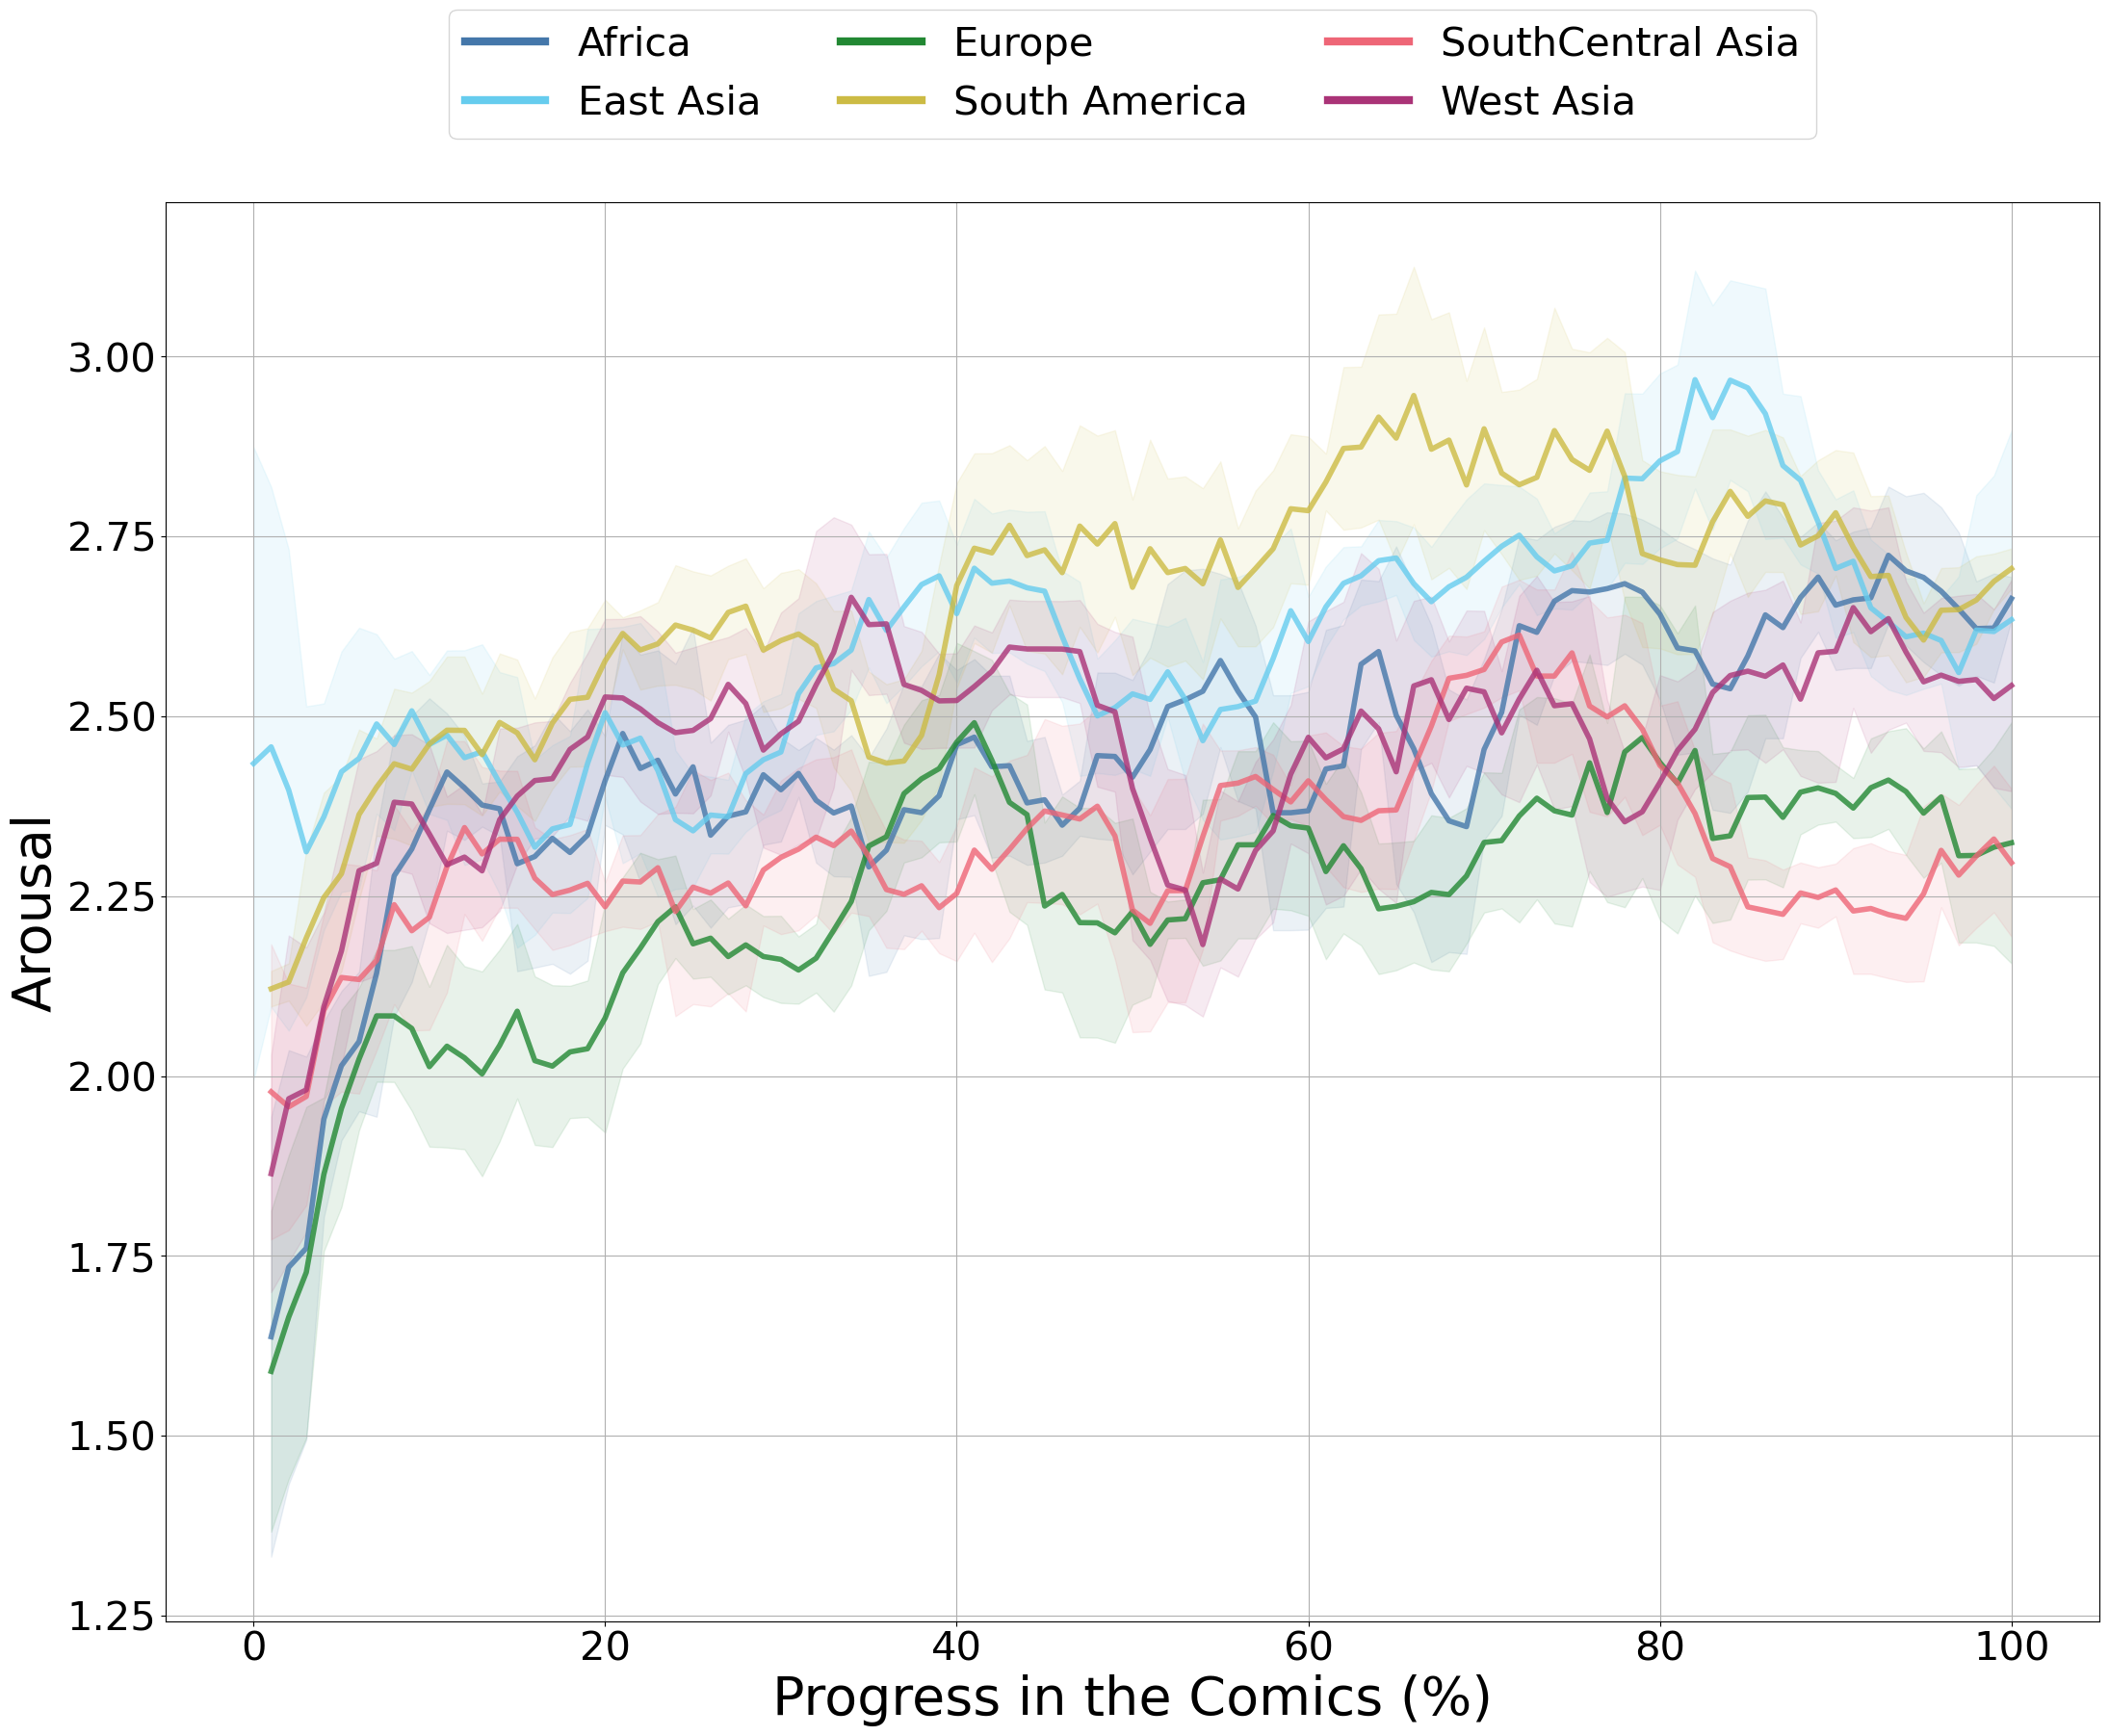

In [6]:
fig1, ax1 = plt.subplots(figsize=(22, 18))

for region, color in region_colors.items():
    region_data = df_region_sample[df_region_sample['RegionSimplified'] == region]
    df_arousal = calculate_metrics(region_data, 'Arousal', 'OrdinalPanel%Rounded2', window)
    ci95 = norm.ppf(0.975)
    df_arousal['Arousal_CI'] = ci95 * df_arousal['Arousal_SE']

    ax1.plot(df_arousal['OrdinalPanel%Rounded2'], df_arousal['Arousal_SMA'], color=color, linewidth=4, alpha=0.8)
    ax1.fill_between(df_arousal['OrdinalPanel%Rounded2'], 
                     df_arousal['Arousal_SMA'] - df_arousal['Arousal_CI'], 
                     df_arousal['Arousal_SMA'] + df_arousal['Arousal_CI'], 
                     color=color, alpha=0.1)

ax1.set_xlabel('Progress in the Comics (%)', fontsize=40)
ax1.set_ylabel('Arousal', fontsize=40)
ax1.grid(True)
ax1.tick_params(axis='both', labelsize=30)

# Add legend
ax1.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=30, frameon=True)

plt.tight_layout()
plt.show()

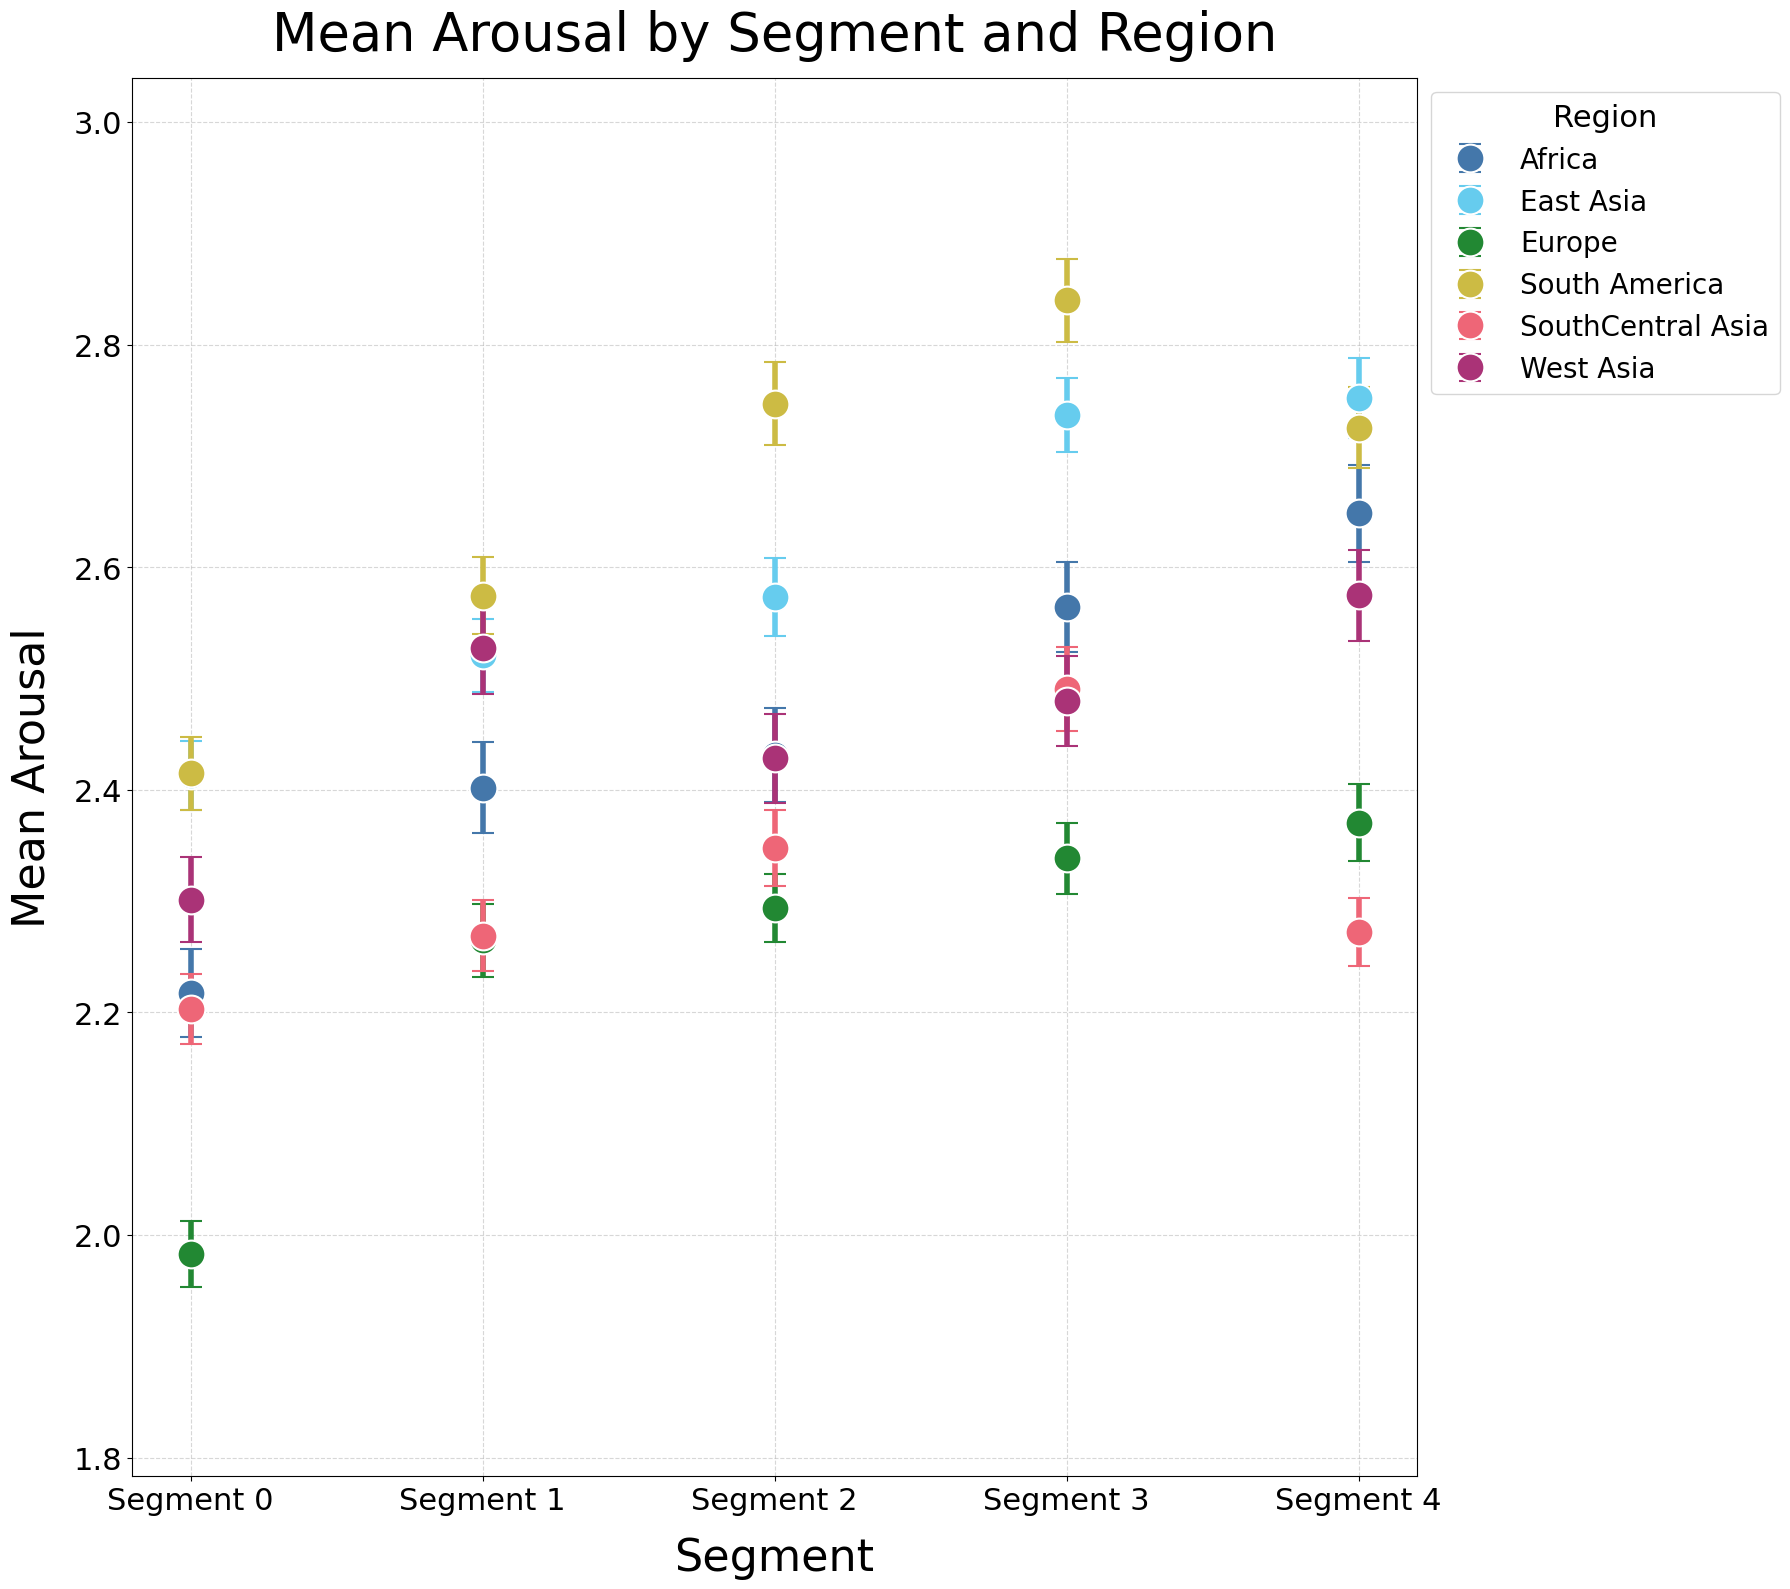

In [7]:
# Create a 'Segment' column by dividing a numeric column into quantiles
df_region_sample['Segment'] = pd.qcut(df_region_sample['OrdinalPanel%Rounded2'], q=5, labels=False)

# Calculate mean and standard error of Arousal for each Region and Segment
arousal_summary = df_region_sample.groupby(['RegionSimplified', 'Segment'])['Arousal'].agg(['mean', 'sem']).reset_index()
arousal_summary.rename(columns={'RegionSimplified': 'Region', 'mean': 'MeanArousal', 'sem': 'SE'}, inplace=True)

# Get the list of unique Region names
region_names = arousal_summary['Region'].unique()

plt.figure(figsize=(18, 16))

# Plot mean Arousal with error bars for each Region
for region in region_names:
    data = arousal_summary[arousal_summary['Region'] == region]
    plt.errorbar(
        data['Segment'], data['MeanArousal'], yerr=data['SE'],
        fmt='o', markersize=20, capsize=8, label=region,
        color=region_colors[region], elinewidth=4,
        markeredgecolor='white', markeredgewidth=1.5
    )

# Set axis labels and title
plt.xlabel('Segment', fontsize=32, labelpad=15)
plt.ylabel('Mean Arousal', fontsize=32, labelpad=15)
plt.title('Mean Arousal by Segment and Region', fontsize=38, pad=20)

# Customize tick labels
plt.xticks(ticks=range(5), labels=[f'Segment {i}' for i in range(5)], fontsize=22)
plt.yticks(fontsize=22)

# Set Y-axis range with some padding
plt.ylim(arousal_summary['MeanArousal'].min() - 0.2, arousal_summary['MeanArousal'].max() + 0.2)

# Add legend and grid
plt.legend(fontsize=20, title='Region', title_fontsize=22, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# Ensure Segment and RegionSimplified are categorical variables
df_region_sample['Segment'] = pd.qcut(df_region_sample['OrdinalPanel%Rounded2'], q=5, labels=False)
df_region_sample['Segment'] = df_region_sample['Segment'].astype('category')
df_region_sample['RegionSimplified'] = df_region_sample['RegionSimplified'].astype('category')

# Fit an OLS model and perform two-way ANOVA
model = ols('Arousal ~ C(RegionSimplified) + C(Segment) + C(RegionSimplified):C(Segment)', data=df_region_sample).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                      sum_sq       df           F  \
C(RegionSimplified)               548.894195      5.0  105.469559   
C(Segment)                        340.031897      4.0   81.671055   
C(RegionSimplified):C(Segment)     74.643011     20.0    3.585648   
Residual                        25304.299991  24311.0         NaN   

                                       PR(>F)  
C(RegionSimplified)             1.617005e-110  
C(Segment)                       5.543825e-69  
C(RegionSimplified):C(Segment)   9.832600e-08  
Residual                                  NaN  


In [9]:
# Check the mean Arousal value for Segment 0 (core validation)
segment0_means = df_region_sample[df_region_sample['Segment'] == 0].groupby('RegionSimplified')['Arousal'].mean()
print(segment0_means.sort_values(ascending=False))

RegionSimplified
South America        2.414791
East Asia            2.413084
West Asia            2.301329
Africa               2.217391
SouthCentral Asia    2.203166
Europe               1.982997
Name: Arousal, dtype: float64


In [10]:
# Check the average Arousal value of Segment 1 (core validation)
segment1_means = df_region_sample[df_region_sample['Segment'] == 1].groupby('RegionSimplified')['Arousal'].mean()
print(segment1_means.sort_values(ascending=False))

RegionSimplified
South America        2.574492
West Asia            2.526965
East Asia            2.520751
Africa               2.401760
SouthCentral Asia    2.268861
Europe               2.264739
Name: Arousal, dtype: float64


In [11]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def tukey_hsd_with_direction_check(df, dv='Arousal', group='RegionSimplified', segment_col='Segment', alpha=0.05, verbose=True):

    # Perform Tukey HSD for each segment and compare the actual mean differences with the Tukey output.

    all_results = []

    segments = df[segment_col].dropna().unique()
    segments = sorted(segments)

    for seg in segments:
        seg_data = df[df[segment_col] == seg].copy()

        # Drop rows with NA in the relevant columns
        seg_data = seg_data[[dv, group]].dropna()
        
        # Calculate group means
        means = seg_data.groupby(group)[dv].mean()

        # Perform Tukey HSD
        tukey = pairwise_tukeyhsd(endog=seg_data[dv],
                                  groups=seg_data[group],
                                  alpha=alpha)

        # Convert Tukey results to DataFrame
        tukey_df = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])

        # Add actual mean difference column
        tukey_df['true_diff'] = tukey_df.apply(lambda row: means[row['group1']] - means[row['group2']], axis=1)
        tukey_df['Segment'] = seg  # Add segment information

        if verbose:
            print(f"\nTukey HSD results and actual mean differences for Segment {seg}:")
            print(tukey_df[['group1', 'group2', 'meandiff', 'true_diff', 'p-adj', 'reject']])

        all_results.append(tukey_df)

    all_results_df = pd.concat(all_results, ignore_index=True)
    return all_results_df

In [12]:
# Ensure categorical variables
df_region_sample['RegionSimplified'] = df_region_sample['RegionSimplified'].astype('category')
df_region_sample['Segment'] = df_region_sample['Segment'].astype('category')

# Run Tukey HSD and check direction of mean differences
tukey_results = tukey_hsd_with_direction_check(df_region_sample)


Tukey HSD results and actual mean differences for Segment 0:
               group1             group2  meandiff  true_diff   p-adj  reject
0              Africa          East Asia    0.1957  -0.195693  0.0006    True
1              Africa             Europe   -0.2344   0.234394  0.0000    True
2              Africa      South America    0.1974  -0.197400  0.0008    True
3              Africa  SouthCentral Asia   -0.0142   0.014225  0.9998   False
4              Africa          West Asia    0.0839  -0.083938  0.6029   False
5           East Asia             Europe   -0.4301   0.430087  0.0000    True
6           East Asia      South America    0.0017  -0.001707  1.0000   False
7           East Asia  SouthCentral Asia   -0.2099   0.209918  0.0001    True
8           East Asia          West Asia   -0.1118   0.111755  0.1794   False
9              Europe      South America    0.4318  -0.431794  0.0000    True
10             Europe  SouthCentral Asia    0.2202  -0.220169  0.0001    True
11

In [19]:
df_region_sample['Segment'] = df_region_sample['Segment'].astype('category')
df_region_sample['RegionSimplified'] = df_region_sample['RegionSimplified'].astype('category')

arousal_posthoc_results = {}

# Perform Tukey HSD test for each Segment
for seg in df_region_sample['Segment'].cat.categories:
    seg_data = df_region_sample[df_region_sample['Segment'] == seg]
    
    tukey = pairwise_tukeyhsd(endog=seg_data['Arousal'],
                              groups=seg_data['RegionSimplified'],
                              alpha=0.05)
    
    print(f'\n Post-hoc Tukey HSD for Segment {seg}:')
    print(tukey.summary())
    
    arousal_posthoc_results[seg] = tukey

# Combine all results and save as CSV
all_arousal_results = []

for seg, tukey in arousal_posthoc_results.items():
    tukey_df = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    tukey_df['Segment'] = seg
    all_arousal_results.append(tukey_df)

arousal_df = pd.concat(all_arousal_results, ignore_index=True)
arousal_df = arousal_df[['Segment', 'group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']]

arousal_df.to_csv("./TukeyHSD_Arousal_Across_Segments.csv", index=False)

print("\n Tukey HSD results for Arousal saved to 'TukeyHSD_Arousal_Across_Segments.csv'")


 Post-hoc Tukey HSD for Segment 0:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
           Africa         East Asia   0.1957 0.0006  0.0602  0.3312   True
           Africa            Europe  -0.2344    0.0 -0.3735 -0.0953   True
           Africa     South America   0.1974 0.0008   0.058  0.3368   True
           Africa SouthCentral Asia  -0.0142 0.9998 -0.1603  0.1318  False
           Africa         West Asia   0.0839 0.6029 -0.0662  0.2341  False
        East Asia            Europe  -0.4301    0.0 -0.5541  -0.306   True
        East Asia     South America   0.0017    1.0 -0.1226   0.126  False
        East Asia SouthCentral Asia  -0.2099 0.0001 -0.3417 -0.0781   True
        East Asia         West Asia  -0.1118 0.1794 -0.2481  0.0246  False
           Europe     South America   0.4318    0.0  0.3035    0

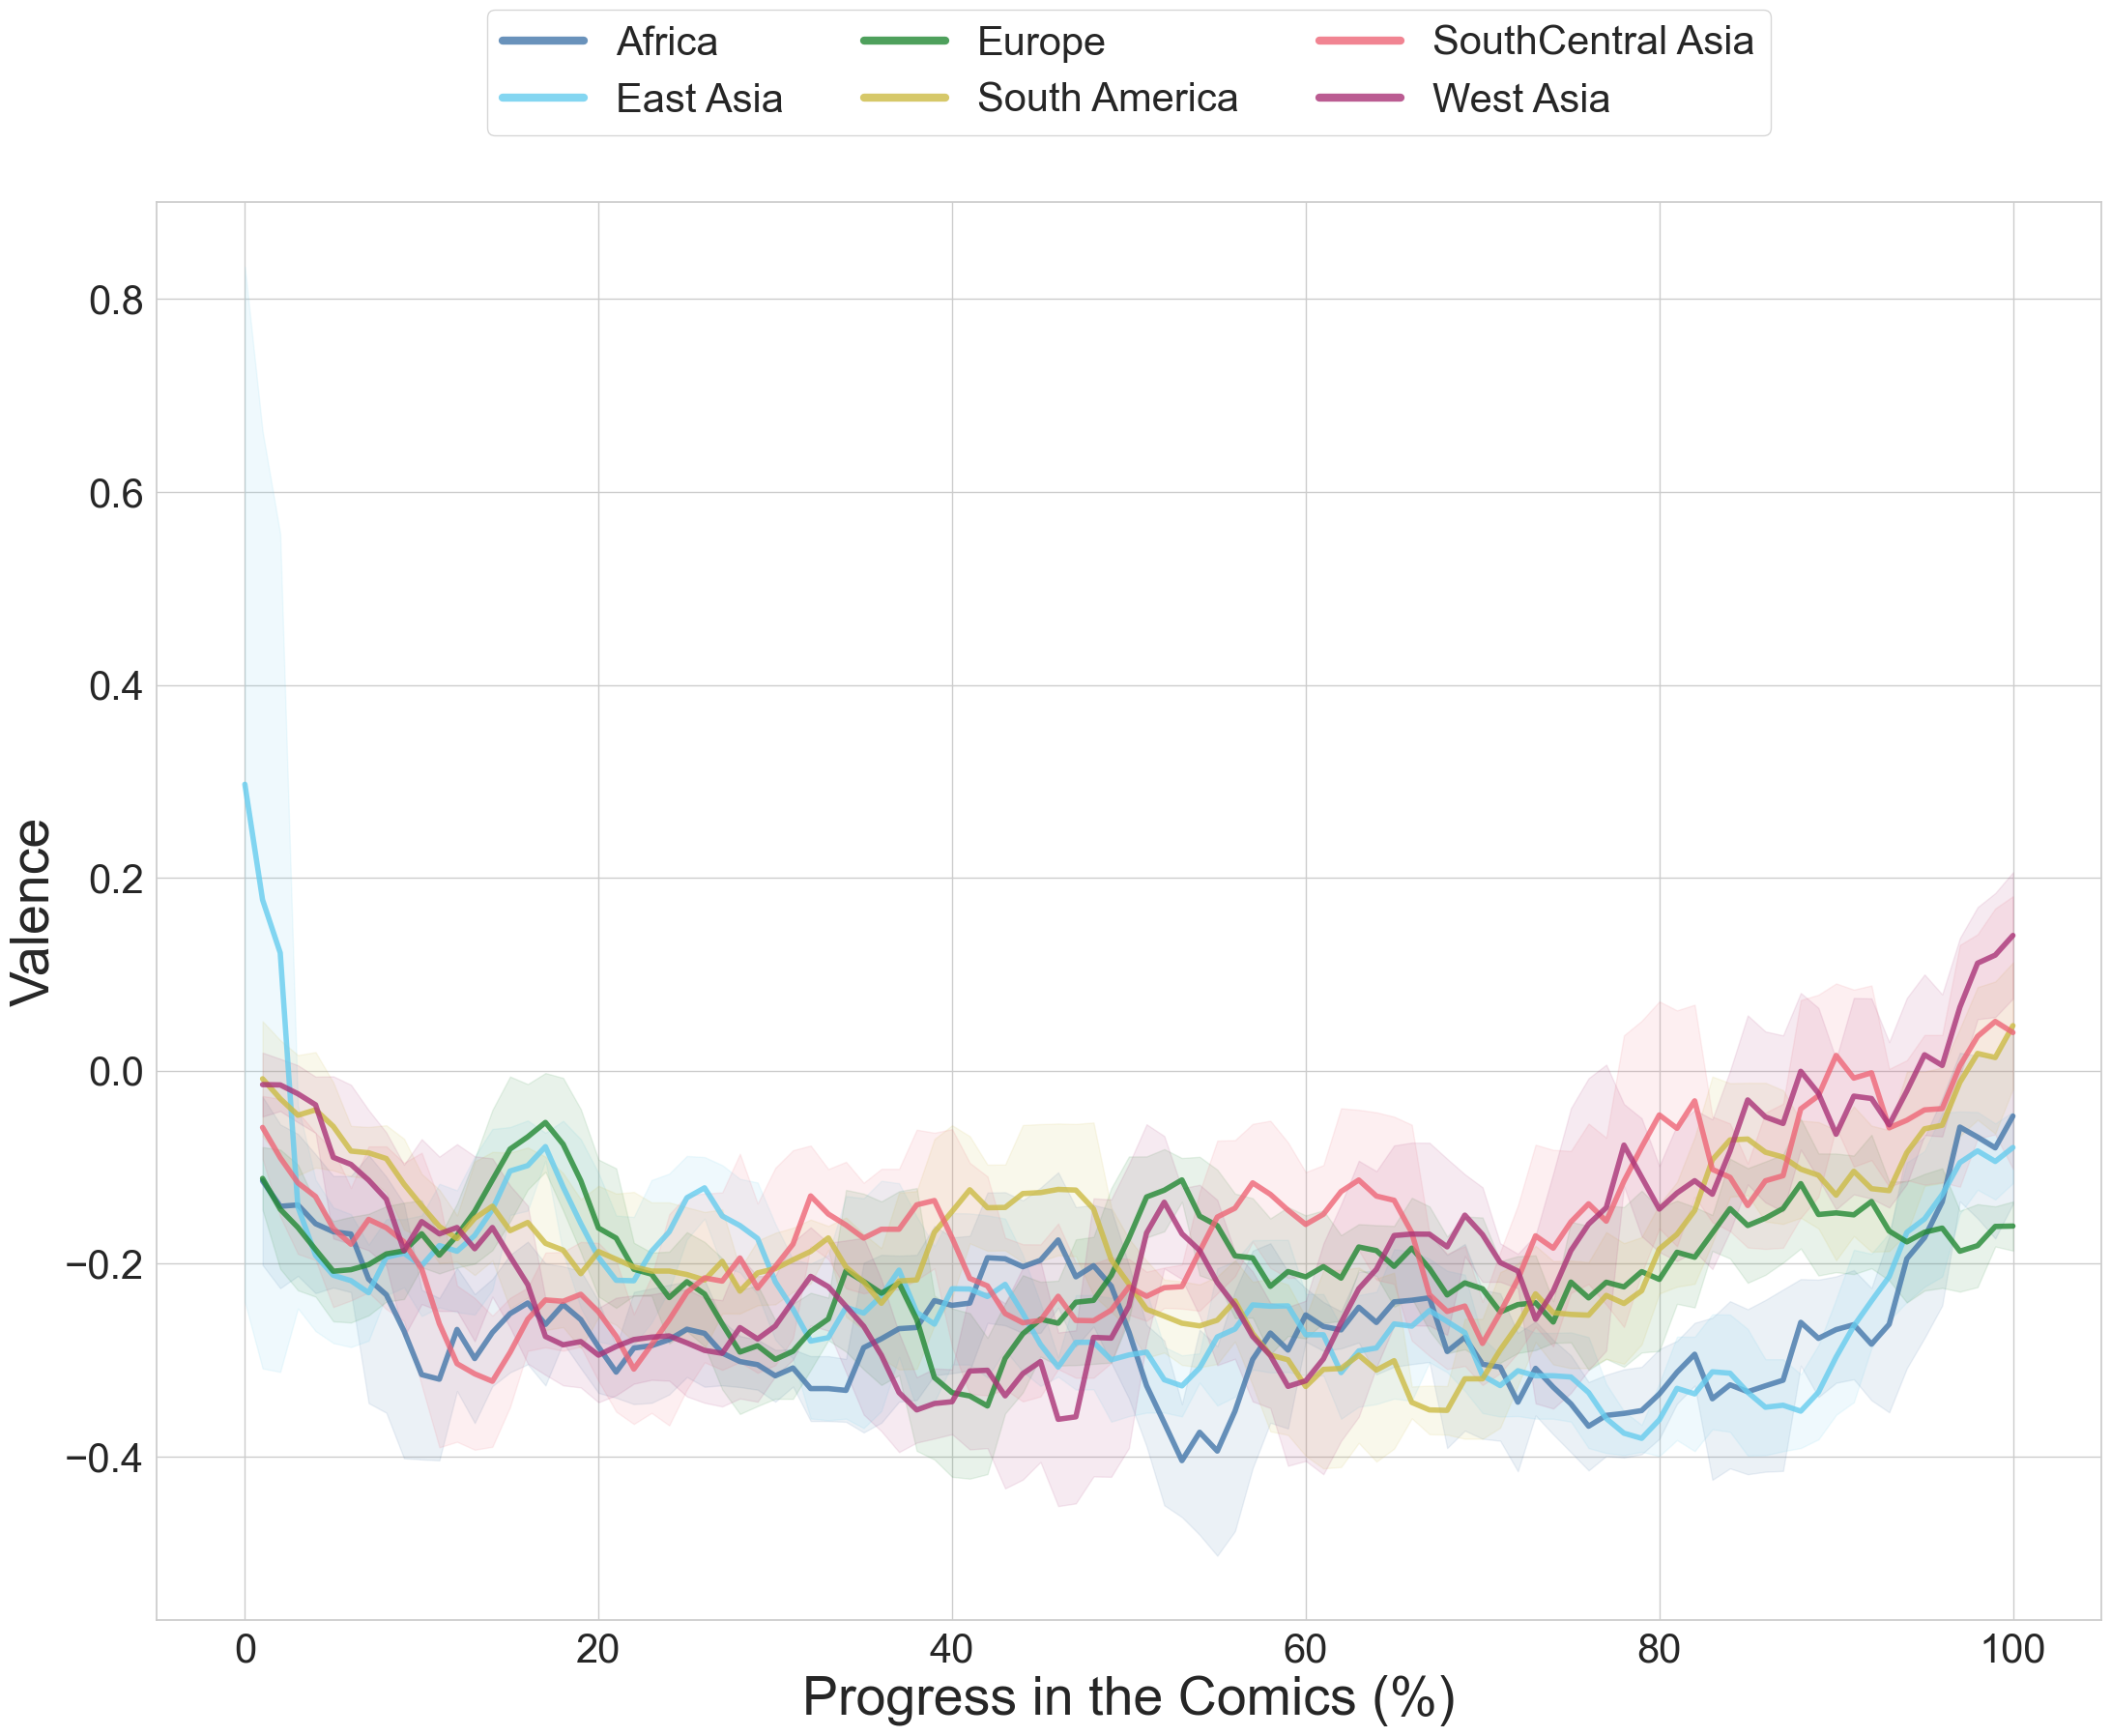

In [25]:
from matplotlib.lines import Line2D

# Set plot style
sns.set(style="whitegrid")

# Colorblind-friendly colors
region_names = ['Africa', 'East Asia', 'Europe', 'South America', 'SouthCentral Asia', 'West Asia']
color_palette = [
    (68/255, 119/255, 170/255),
    (102/255, 204/255, 238/255), 
    (34/255, 136/255, 51/255),
    (204/255, 187/255, 68/255),
    (238/255, 102/255, 119/255),
    (170/255, 51/255, 119/255)
]

# Match colors with regions
region_colors = dict(zip(region_names, color_palette))

def calculate_metrics(data, value_col, index_col, window):
    mean_valence_by_panel = data.groupby(index_col)[value_col].mean().reset_index()
    mean_valence_by_panel['Valence_SMA'] = mean_valence_by_panel[value_col].rolling(window=window, min_periods=1, center=True).mean()
    mean_valence_by_panel['Valence_SE'] = mean_valence_by_panel[value_col].rolling(window=window, min_periods=1, center=True).std() / np.sqrt(window)
    mean_valence_by_panel[index_col] = mean_valence_by_panel[index_col] * 100
    return mean_valence_by_panel

# Define the rolling window size
window = 5

# Create the plot for Valence with confidence intervals
fig, ax2 = plt.subplots(figsize=(22, 18))

for region, color in region_colors.items():
    region_data = df_region_sample[df_region_sample['RegionSimplified'] == region]
    mean_valence_by_panel = calculate_metrics(region_data, 'Valence#', 'OrdinalPanel%Rounded2', window)
    
    # Calculate 97.5% confidence interval
    ci95 = norm.ppf(0.975)
    mean_valence_by_panel['Valence_CI'] = ci95 * mean_valence_by_panel['Valence_SE']

    # Plot SMA line for Valence
    ax2.plot(mean_valence_by_panel['OrdinalPanel%Rounded2'], mean_valence_by_panel['Valence_SMA'], color=color, linewidth=4, label=f'{region}', alpha=0.8)
    
    # Plot confidence interval for Valence
    ax2.fill_between(mean_valence_by_panel['OrdinalPanel%Rounded2'], 
                     mean_valence_by_panel['Valence_SMA'] - mean_valence_by_panel['Valence_CI'], 
                     mean_valence_by_panel['Valence_SMA'] + mean_valence_by_panel['Valence_CI'], 
                     color=color, alpha=0.1)

ax2.set_title('', fontsize=40)
ax2.set_xlabel('Progress in the Comics (%)', fontsize=40)
ax2.set_ylabel('Valence', fontsize=40)

legend = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=30)

for line in legend.get_lines():
    line.set_linewidth(6)

ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()
plt.show()

In [27]:
valence_summary = df_region_sample.groupby(['RegionSimplified', 'Segment'])['Valence#'].agg(['mean', 'sem']).reset_index()
valence_summary.rename(columns={'RegionSimplified': 'Region', 'mean': 'MeanValence', 'sem': 'SE'}, inplace=True)

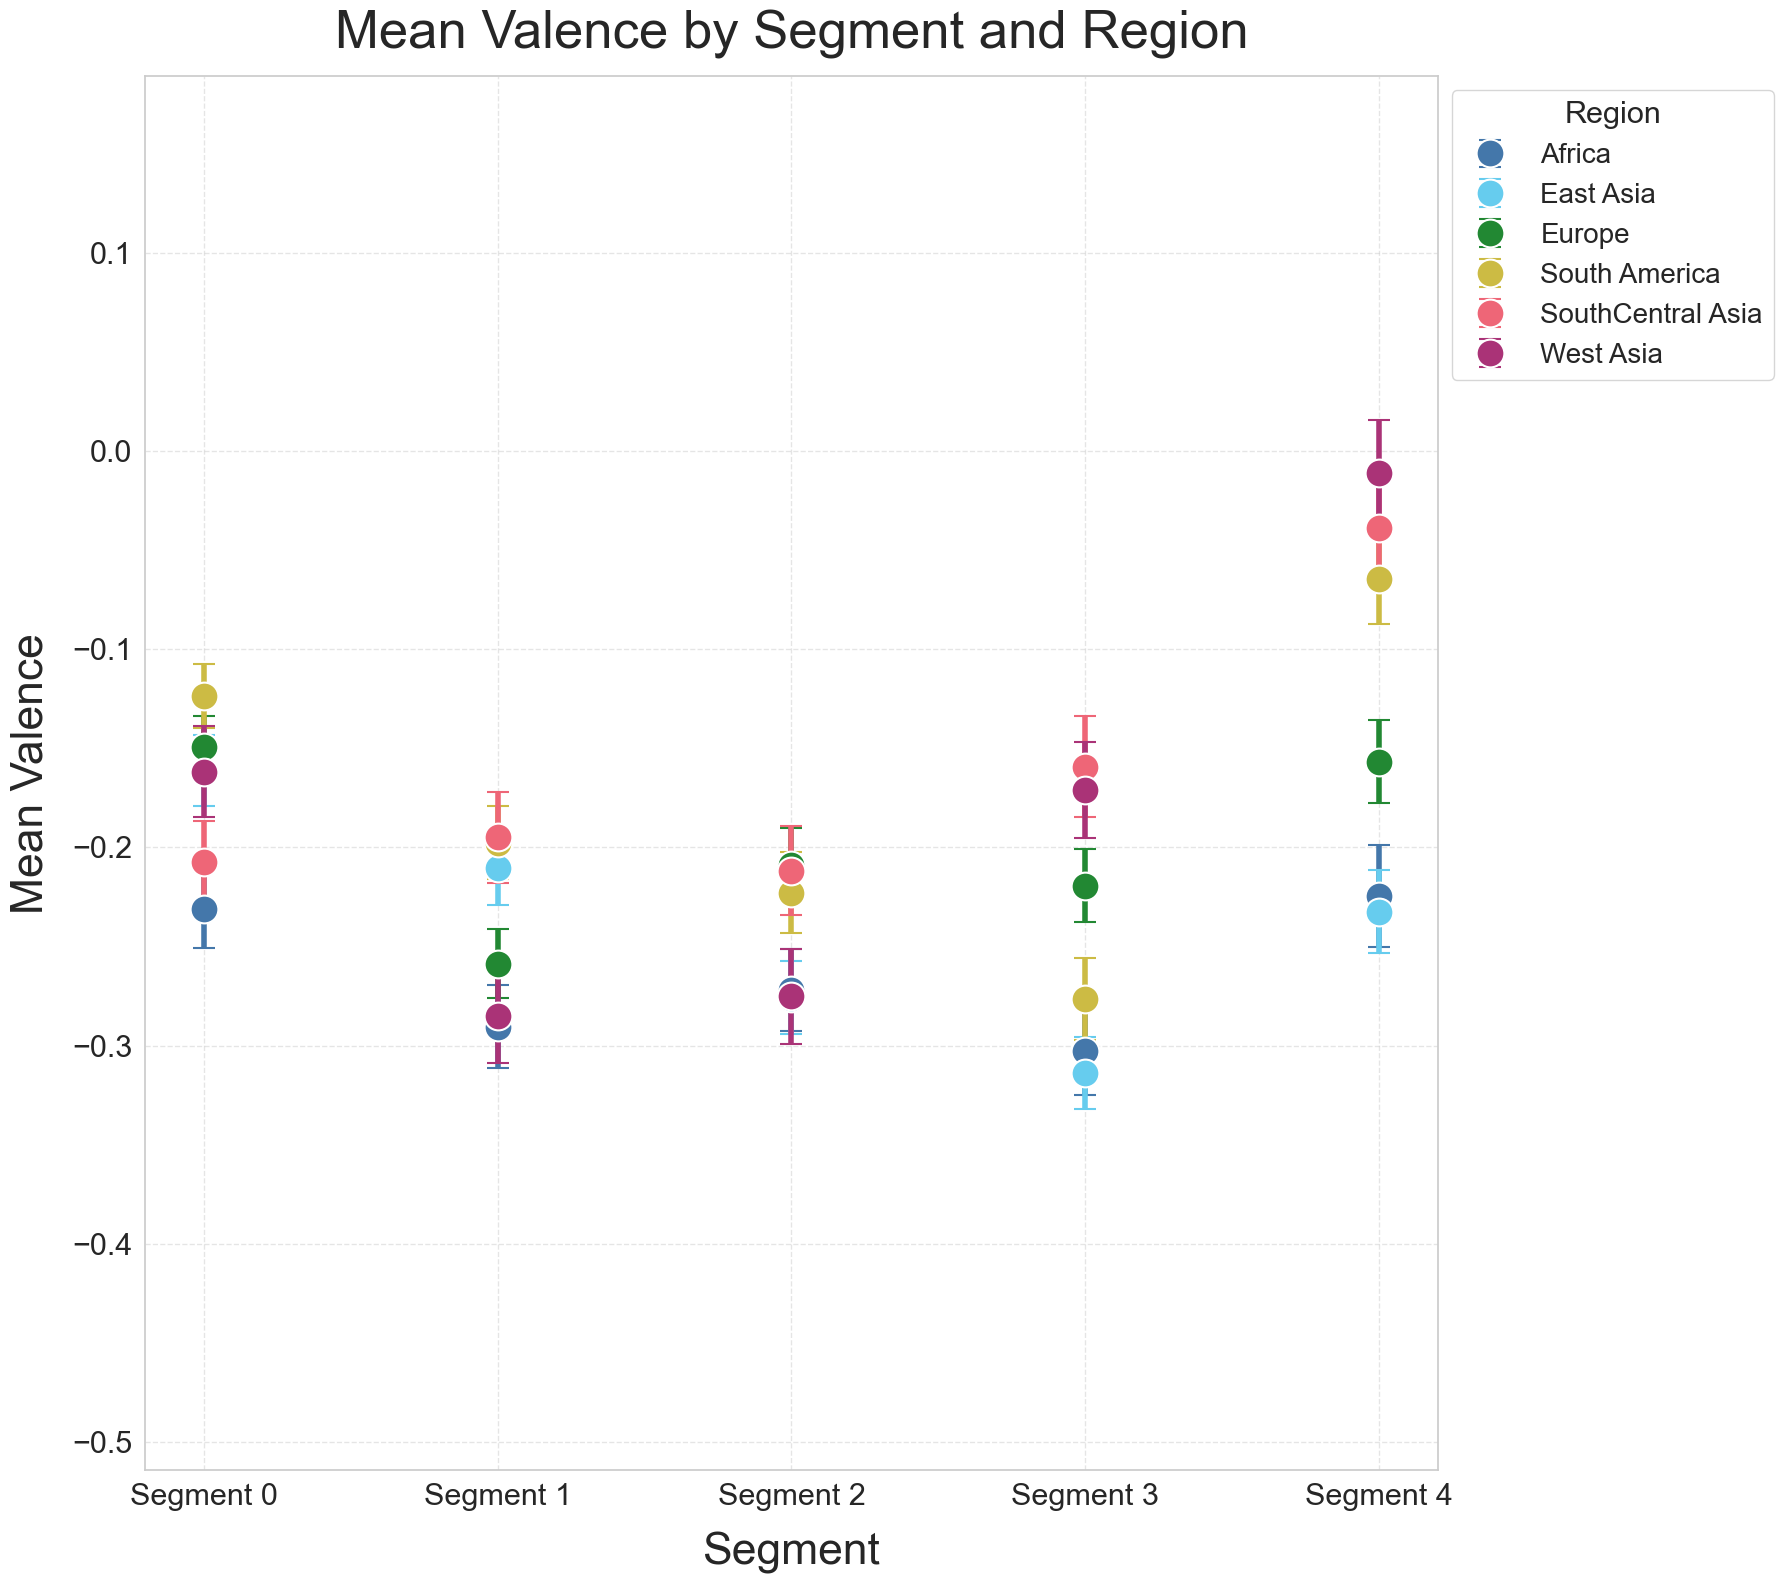

In [29]:
region_names = valence_summary['Region'].unique()

plt.figure(figsize=(18, 16))

for region in region_names:
    data = valence_summary[valence_summary['Region'] == region]
    plt.errorbar(
        data['Segment'], data['MeanValence'], yerr=data['SE'],
        fmt='o', markersize=20, capsize=8, label=region,
        color=region_colors[region], elinewidth=4,
        markeredgecolor='white', markeredgewidth=1.5
    )

plt.xlabel('Segment', fontsize=32, labelpad=15)
plt.ylabel('Mean Valence', fontsize=32, labelpad=15)
plt.title('Mean Valence by Segment and Region', fontsize=38, pad=20)

plt.xticks(ticks=range(5), labels=[f'Segment {i}' for i in range(5)], fontsize=22)
plt.yticks(fontsize=22)

# Automatically set y-axis range with some padding
plt.ylim(valence_summary['MeanValence'].min() - 0.2, valence_summary['MeanValence'].max() + 0.2)

plt.legend(fontsize=20, title='Region', title_fontsize=22, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [32]:
# Ensure Segment and Region are categorical variables
df_region_sample['Segment'] = pd.qcut(df_region_sample['OrdinalPanel%Rounded2'], q=5, labels=False)
df_region_sample['Segment'] = df_region_sample['Segment'].astype('category')
df_region_sample['RegionSimplified'] = df_region_sample['RegionSimplified'].astype('category')

df_region_sample.rename(columns={'Valence#': 'Valence'}, inplace=True)

# Two-way ANOVA
model_valence = ols('Valence ~ C(RegionSimplified) + C(Segment) + C(RegionSimplified):C(Segment)', data=df_region_sample).fit()
anova_table_valence = sm.stats.anova_lm(model_valence, typ=2)

# Output results
print(anova_table_valence)

                                     sum_sq       df          F        PR(>F)
C(RegionSimplified)               29.007934      5.0  16.666655  1.797935e-16
C(Segment)                        54.300317      4.0  38.998152  1.348068e-32
C(RegionSimplified):C(Segment)    41.341294     20.0   5.938212  5.358698e-16
Residual                        8462.548370  24311.0        NaN           NaN


In [33]:
df_region_sample['Segment'] = df_region_sample['Segment'].astype('category')
df_region_sample['RegionSimplified'] = df_region_sample['RegionSimplified'].astype('category')

valence_posthoc_results = {}

# Perform Tukey comparison for each Segment (Region comparison)
for seg in df_region_sample['Segment'].cat.categories:
    seg_data = df_region_sample[df_region_sample['Segment'] == seg]
    
    tukey = pairwise_tukeyhsd(endog=seg_data['Valence'],
                              groups=seg_data['RegionSimplified'],
                              alpha=0.05)
    
    print(f'\n Post-hoc Tukey HSD for Segment {seg}:')
    print(tukey.summary())
    
    valence_posthoc_results[seg] = tukey


 Post-hoc Tukey HSD for Segment 0:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
           Africa         East Asia   0.0699 0.0827 -0.0049  0.1448  False
           Africa            Europe   0.0819 0.0289   0.005  0.1587   True
           Africa     South America   0.1074  0.001  0.0304  0.1843   True
           Africa SouthCentral Asia    0.024 0.9581 -0.0566  0.1047  False
           Africa         West Asia   0.0694  0.161 -0.0135  0.1523  False
        East Asia            Europe   0.0119 0.9963 -0.0566  0.0804  False
        East Asia     South America   0.0374 0.6292 -0.0312  0.1061  False
        East Asia SouthCentral Asia  -0.0459 0.4667 -0.1187  0.0269  False
        East Asia         West Asia  -0.0005    1.0 -0.0758  0.0747  False
           Europe     South America   0.0255 0.9089 -0.0453  0.0

In [34]:
# Ensure correct data types
df_region_sample['Segment'] = df_region_sample['Segment'].astype('category')
df_region_sample['RegionSimplified'] = df_region_sample['RegionSimplified'].astype('category')

# Store all Tukey result rows
all_tukey_results = []

for seg in df_region_sample['Segment'].cat.categories:
    seg_data = df_region_sample[df_region_sample['Segment'] == seg]
    
    tukey = pairwise_tukeyhsd(endog=seg_data['Valence'],
                              groups=seg_data['RegionSimplified'],
                              alpha=0.05)
    
    print(f'\n Post-hoc Tukey HSD for Segment {seg}:')
    print(tukey.summary())
    
    # Convert Tukey results to DataFrame
    tukey_df = pd.DataFrame(data=tukey._results_table.data[1:],  # Skip header row
                            columns=tukey._results_table.data[0])
    
    # Add Segment information
    tukey_df['Segment'] = seg
    
    # Save to results list
    all_tukey_results.append(tukey_df)

# Combine results from all segments
final_df = pd.concat(all_tukey_results, ignore_index=True)

# Adjust column order
final_df = final_df[['Segment', 'group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']]

final_df.to_csv("Tukey_HSD_Results_Across_Segments.csv", index=False)

print("\n Tukey HSD results saved to 'Tukey_HSD_Results_Across_Segments.csv'")


 Post-hoc Tukey HSD for Segment 0:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
           Africa         East Asia   0.0699 0.0827 -0.0049  0.1448  False
           Africa            Europe   0.0819 0.0289   0.005  0.1587   True
           Africa     South America   0.1074  0.001  0.0304  0.1843   True
           Africa SouthCentral Asia    0.024 0.9581 -0.0566  0.1047  False
           Africa         West Asia   0.0694  0.161 -0.0135  0.1523  False
        East Asia            Europe   0.0119 0.9963 -0.0566  0.0804  False
        East Asia     South America   0.0374 0.6292 -0.0312  0.1061  False
        East Asia SouthCentral Asia  -0.0459 0.4667 -0.1187  0.0269  False
        East Asia         West Asia  -0.0005    1.0 -0.0758  0.0747  False
           Europe     South America   0.0255 0.9089 -0.0453  0.0

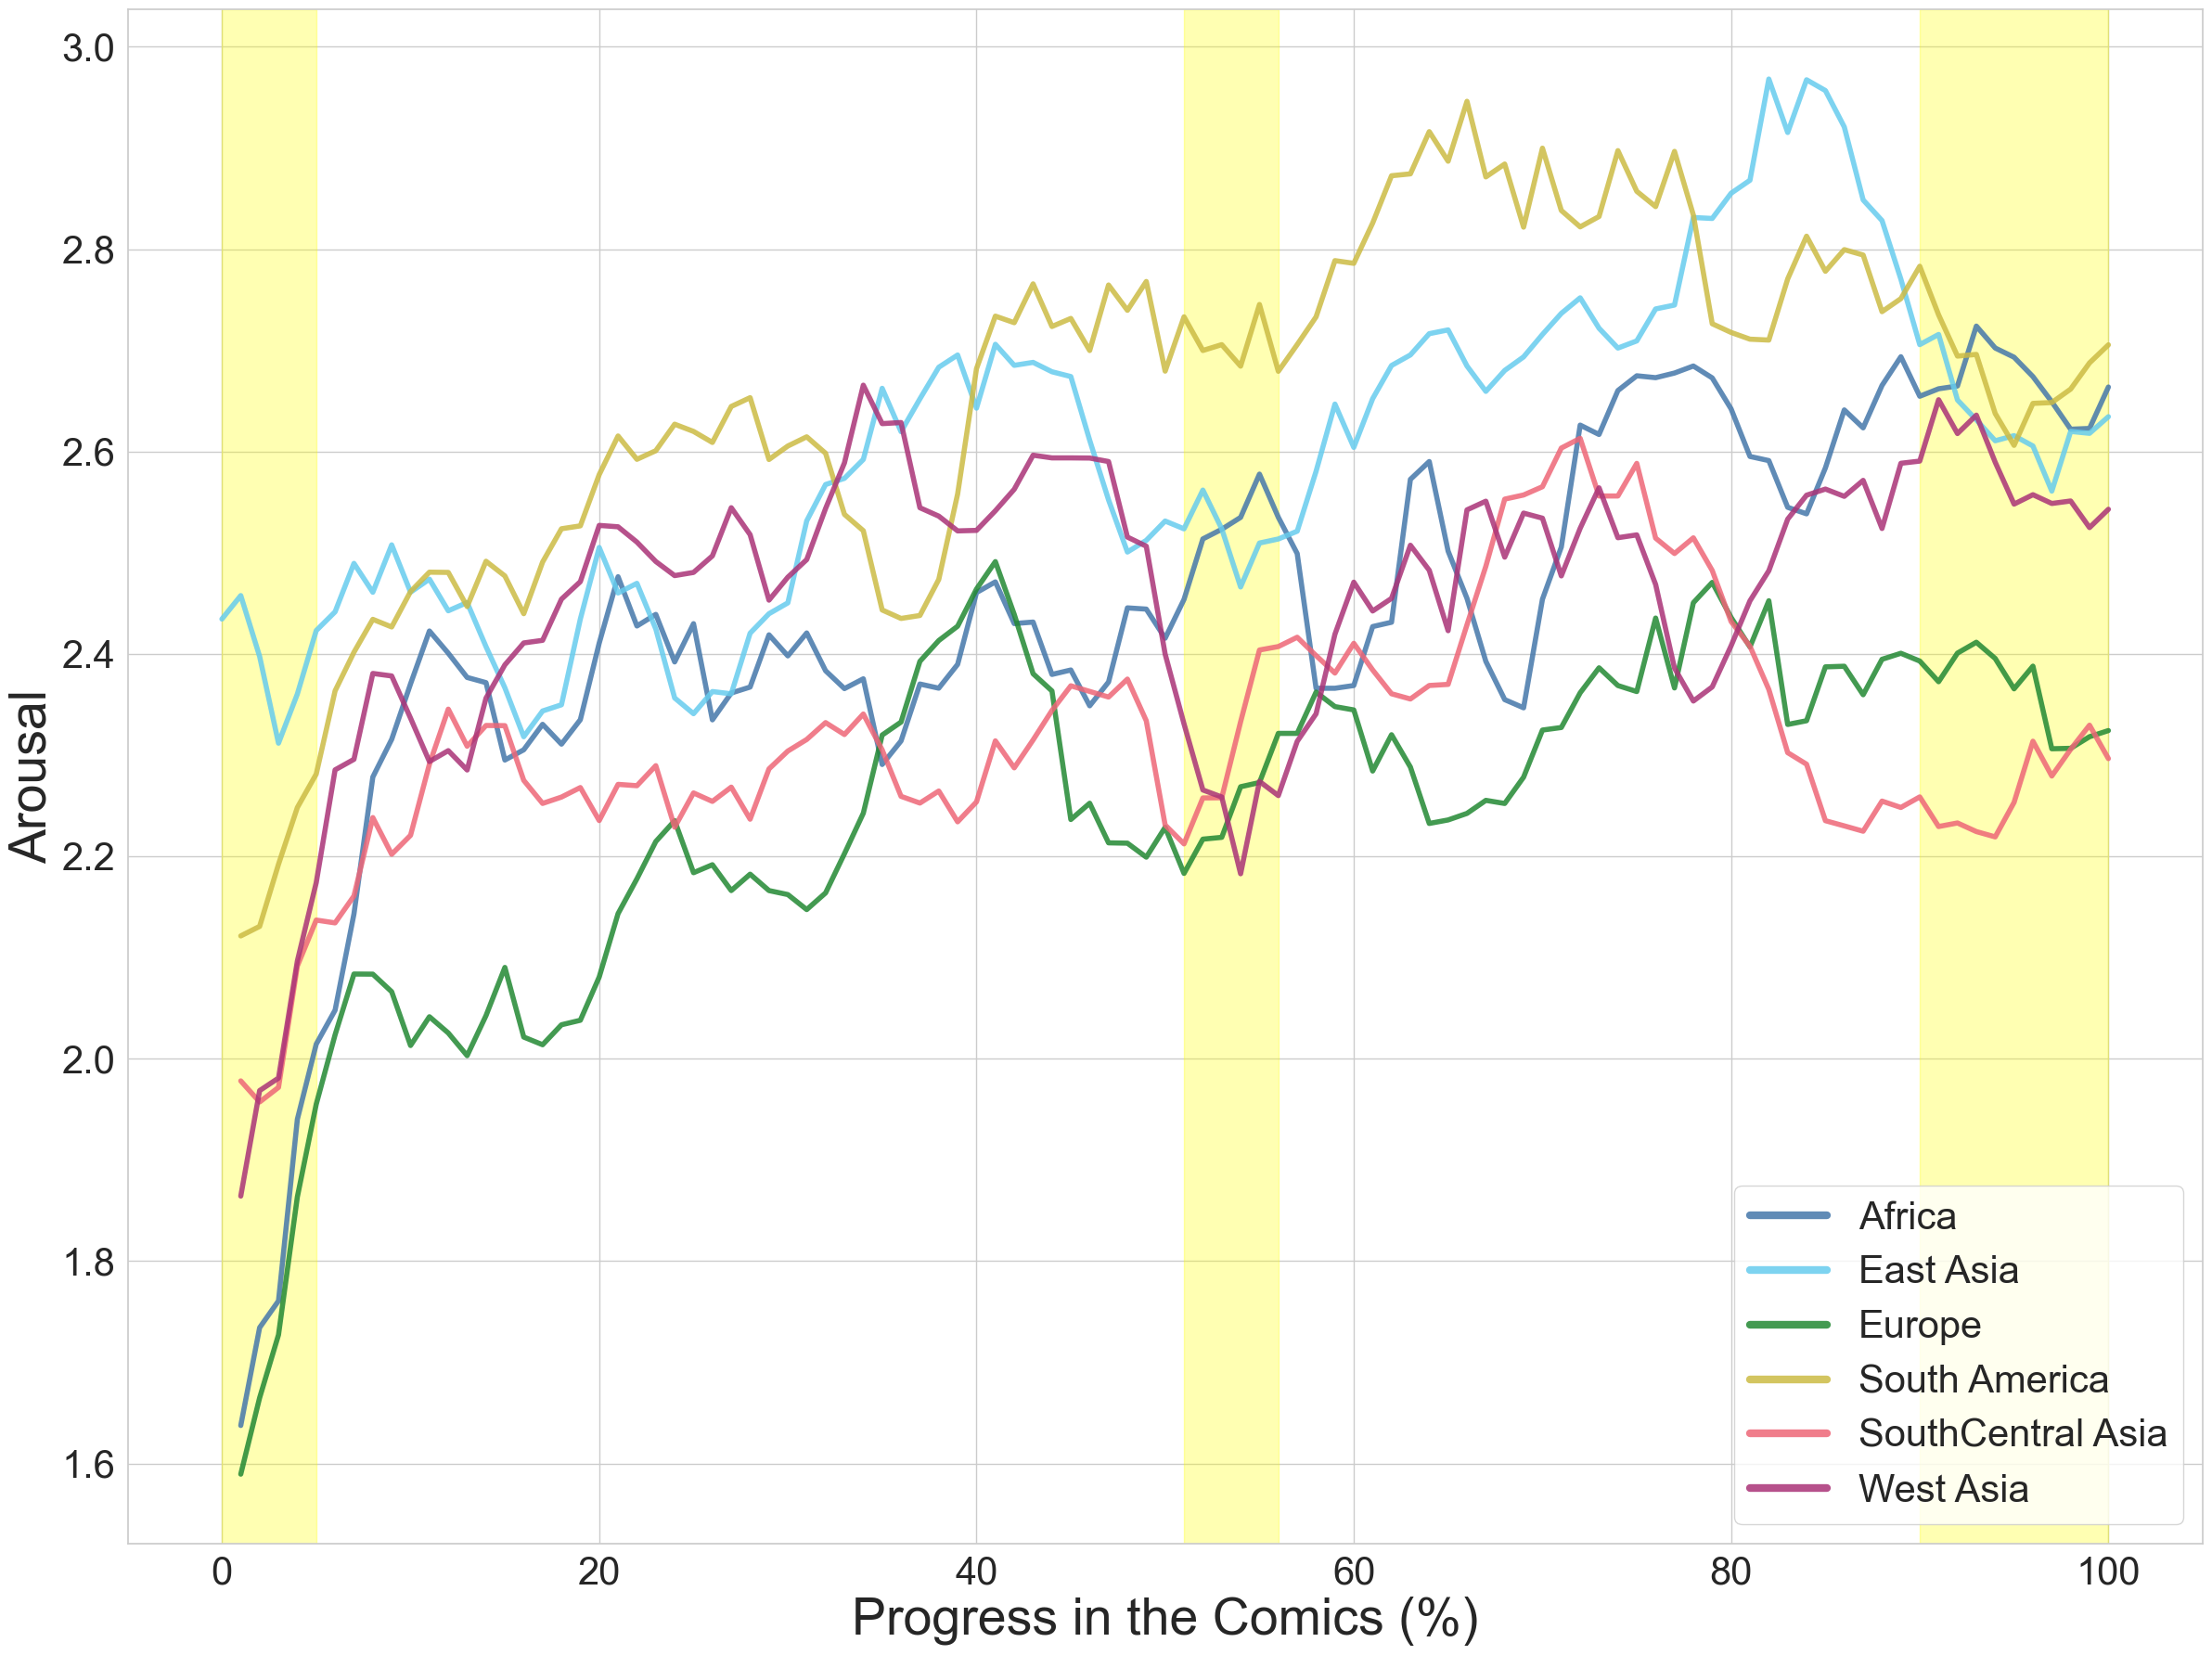

In [35]:
sns.set(style="whitegrid")

region_names = ['Africa', 'East Asia', 'Europe', 'South America', 'SouthCentral Asia', 'West Asia']
color_palette = [
    (68/255, 119/255, 170/255),  
    (102/255, 204/255, 238/255), 
    (34/255, 136/255, 51/255),
    (204/255, 187/255, 68/255),
    (238/255, 102/255, 119/255), 
    (170/255, 51/255, 119/255) 
]

region_colors = dict(zip(region_names, color_palette))

def calculate_metrics(data, value_col, index_col, window):
    mean_arousal_by_panel = data.groupby(index_col)[value_col].mean().reset_index()
    mean_arousal_by_panel['Arousal_SMA'] = mean_arousal_by_panel[value_col].rolling(window=window, min_periods=1, center=True).mean()
    mean_arousal_by_panel[index_col] = mean_arousal_by_panel[index_col] * 100  # scale to %
    return mean_arousal_by_panel

window = 5

fig, ax = plt.subplots(figsize=(24, 18))

# Add yellow highlight regions (note: units are in %)
highlight_regions = [(0, 5), (51, 56), (90, 100)]
for start, end in highlight_regions:
    ax.axvspan(start, end, color='yellow', alpha=0.3)

# Plot curves for each region (without confidence intervals)
for region, color in region_colors.items():
    region_data = df_region_sample[df_region_sample['RegionSimplified'] == region]
    mean_vals = calculate_metrics(region_data, 'Arousal', 'OrdinalPanel%Rounded2', window)
    
    ax.plot(mean_vals['OrdinalPanel%Rounded2'], 
            mean_vals['Arousal_SMA'], 
            color=color, linewidth=4, label=region, alpha=0.85)

# Legend and axis formatting
legend = ax.legend(loc='lower right', fontsize=30, frameon=True)
for line in legend.get_lines():
    line.set_linewidth(6)

ax.set_xlabel('Progress in the Comics (%)', fontsize=40)
ax.set_ylabel('Arousal', fontsize=40)
ax.tick_params(axis='both', labelsize=30)
ax.grid(True)
plt.tight_layout()
plt.show()

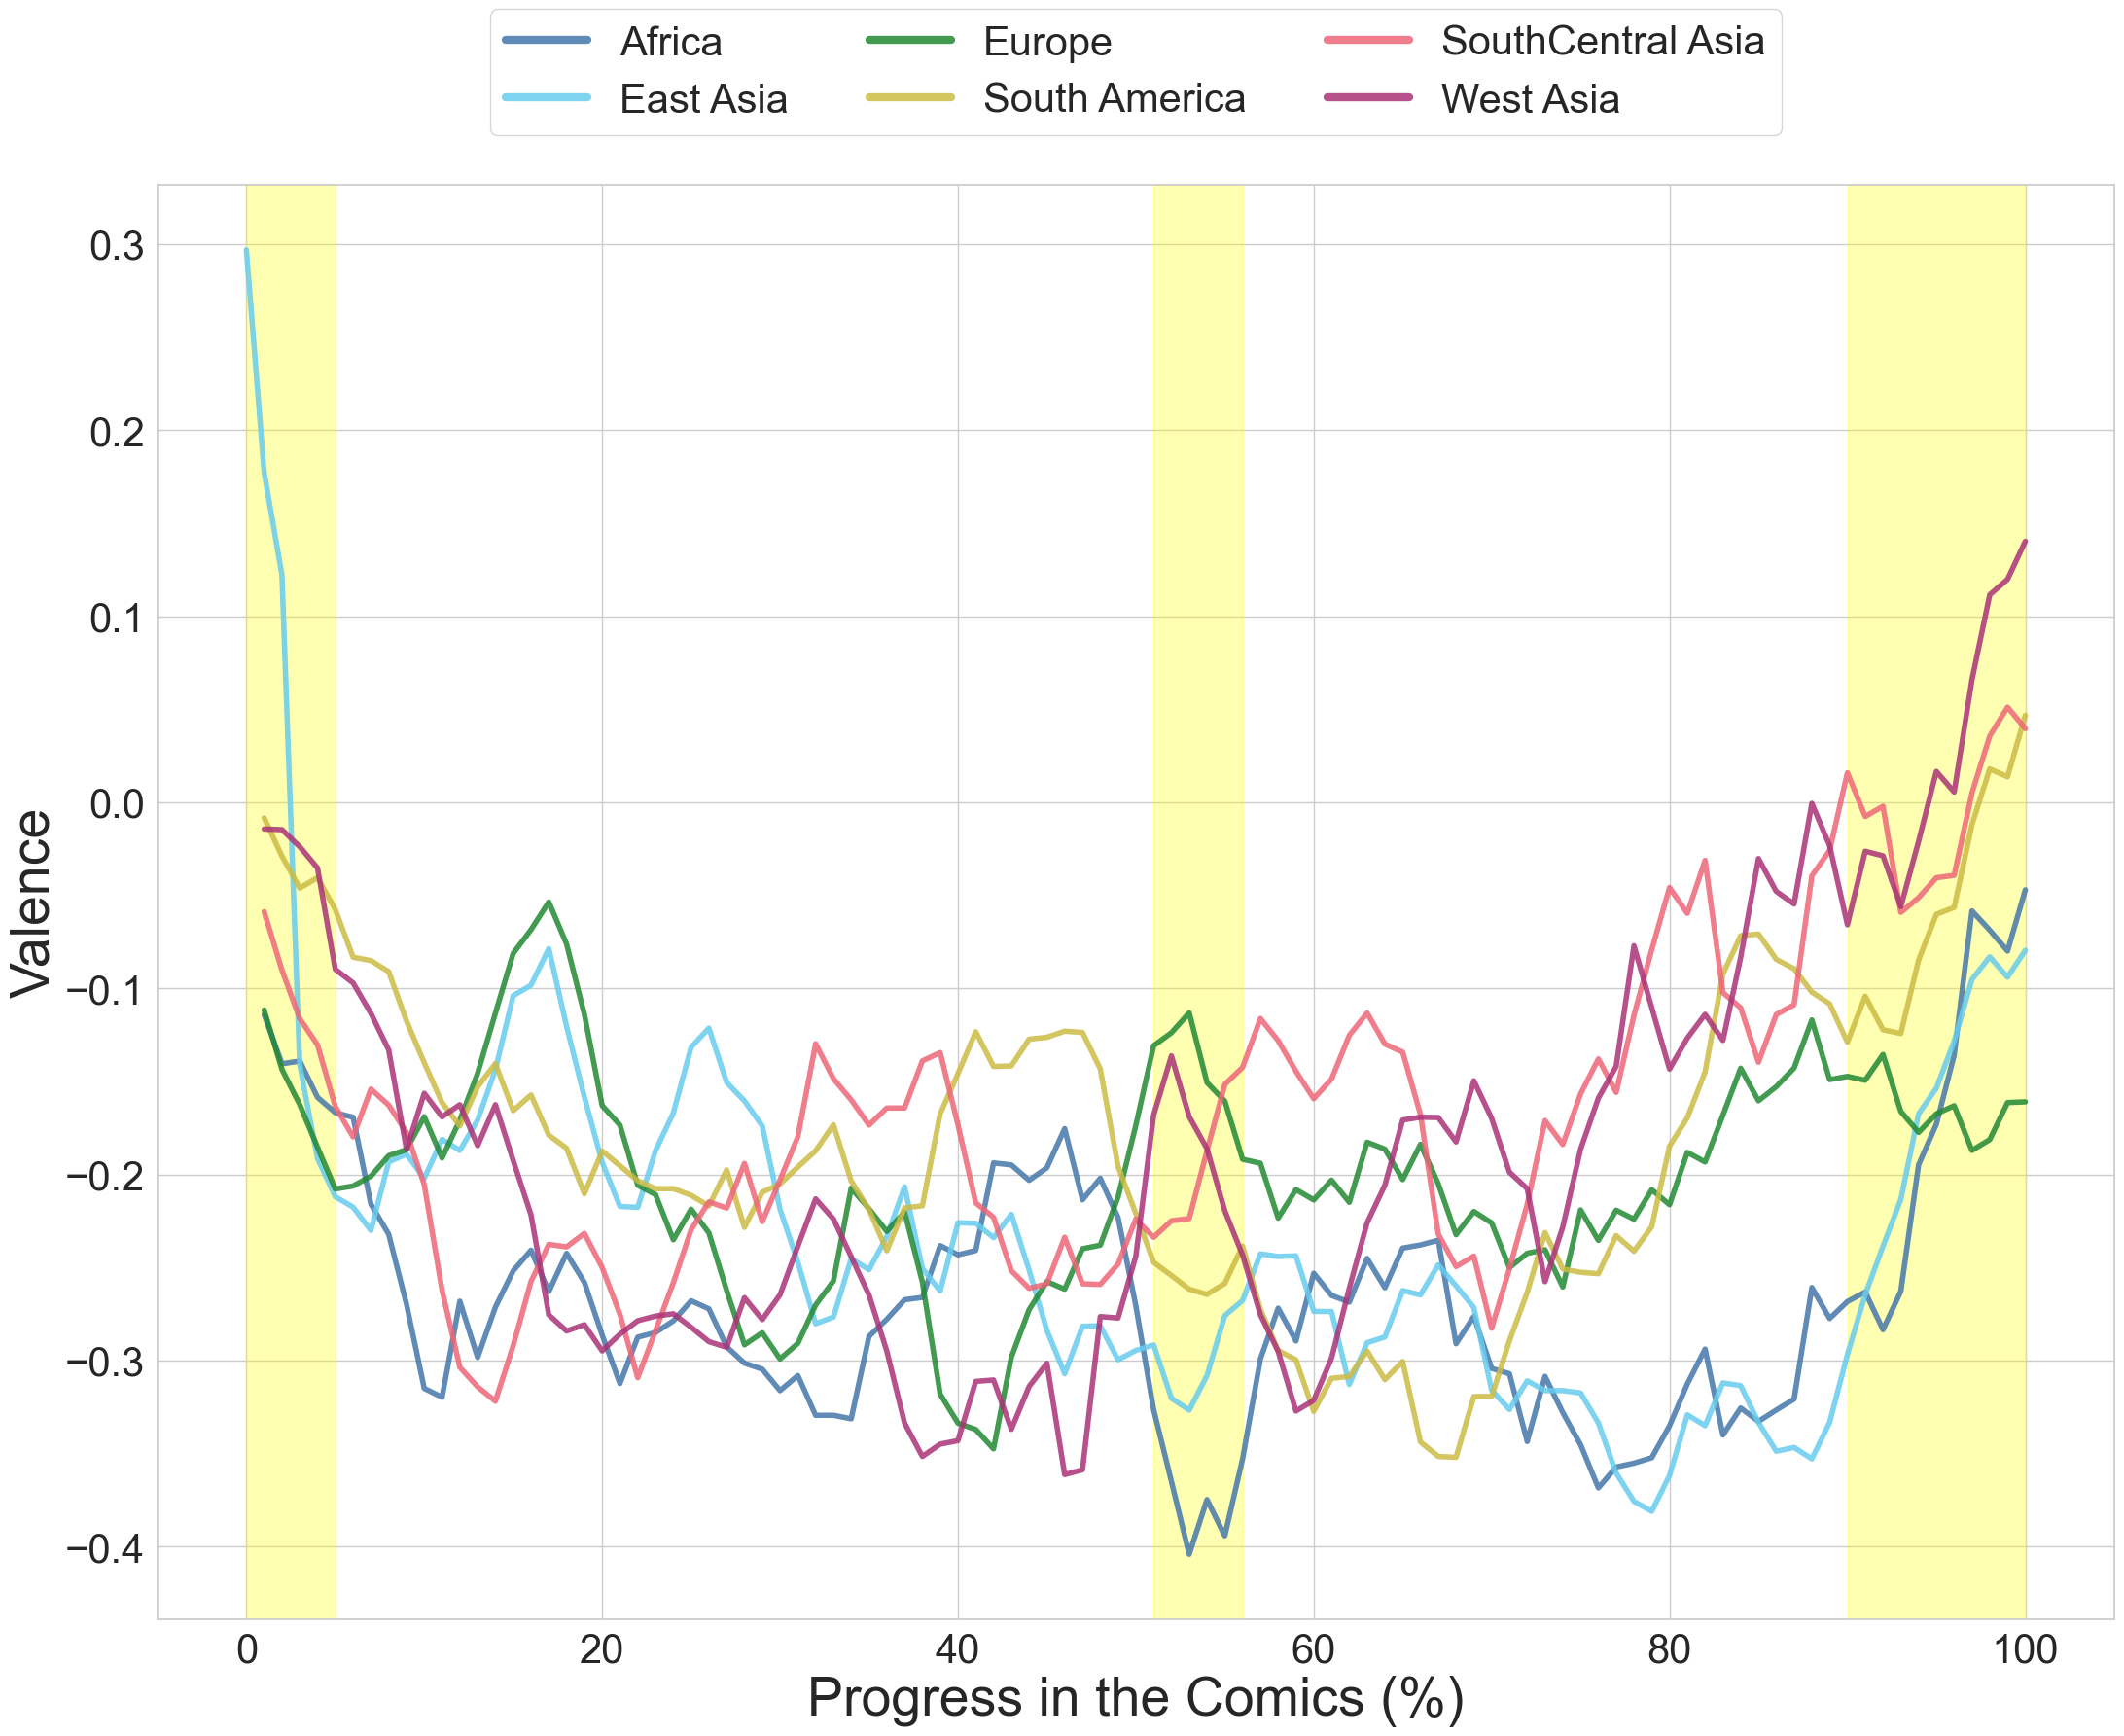

In [36]:
sns.set(style="whitegrid")

region_names = ['Africa', 'East Asia', 'Europe', 'South America', 'SouthCentral Asia', 'West Asia']
color_palette = [
    (68/255, 119/255, 170/255), 
    (102/255, 204/255, 238/255), 
    (34/255, 136/255, 51/255),  
    (204/255, 187/255, 68/255), 
    (238/255, 102/255, 119/255), 
    (170/255, 51/255, 119/255)  
]

region_colors = dict(zip(region_names, color_palette))

def calculate_valence_metrics(data, value_col, index_col, window):
    mean_valence_by_panel = data.groupby(index_col)[value_col].mean().reset_index()
    mean_valence_by_panel['Valence_SMA'] = mean_valence_by_panel[value_col].rolling(window=window, min_periods=1, center=True).mean()
    mean_valence_by_panel[index_col] = mean_valence_by_panel[index_col] * 100  # scale to %
    return mean_valence_by_panel

window = 5

fig, ax = plt.subplots(figsize=(22, 18))

highlight_regions = [(0, 5), (51, 56), (90, 100)]
for start, end in highlight_regions:
    ax.axvspan(start, end, color='yellow', alpha=0.3)

for region, color in region_colors.items():
    region_data = df_region_sample[df_region_sample['RegionSimplified'] == region]
    mean_vals = calculate_valence_metrics(region_data, 'Valence', 'OrdinalPanel%Rounded2', window)
    
    ax.plot(mean_vals['OrdinalPanel%Rounded2'], 
            mean_vals['Valence_SMA'], 
            color=color, linewidth=4, label=region, alpha=0.85)

legend = ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    fontsize=30,
    frameon=True,
    ncol=3  
)

for line in legend.get_lines():
    line.set_linewidth(6)

ax.set_xlabel('Progress in the Comics (%)', fontsize=40)
ax.set_ylabel('Valence', fontsize=40)
ax.tick_params(axis='both', labelsize=30)
ax.grid(True)
plt.tight_layout()
plt.show()

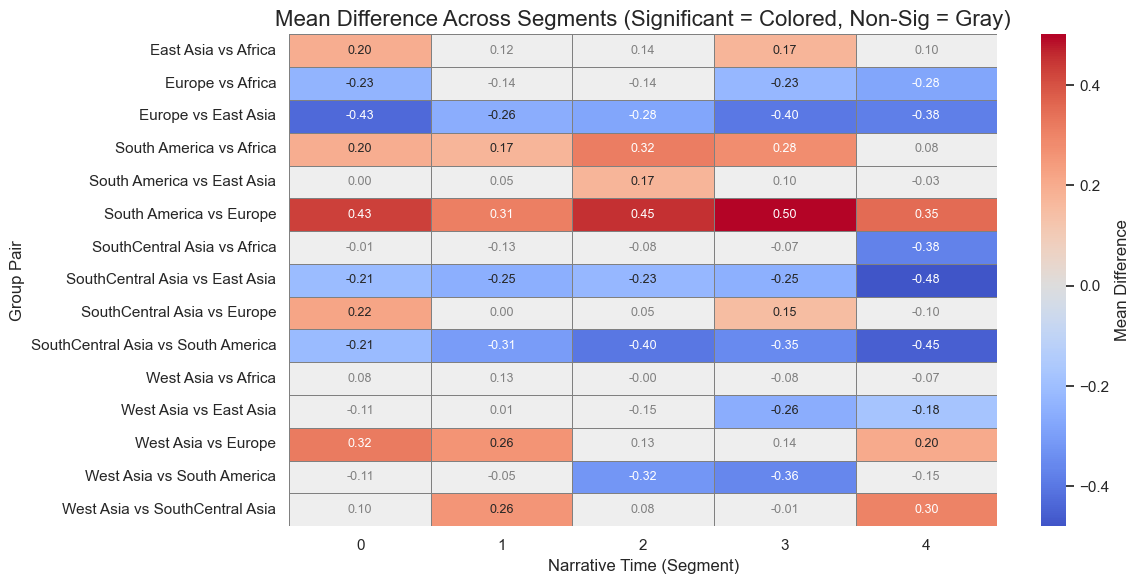

In [44]:
df = pd.read_csv("1TukeyHSD_Arousal_Across_Segments.csv")

# Create group2 vs group1 
df["Group Pair"] = df["group2"] + " vs " + df["group1"]

# Pivot table: mean differences & significance boolean values
pivot_means = df.pivot(index="Group Pair", columns="Segment", values="meandiff")
significance_mask = df.pivot(index="Group Pair", columns="Segment", values="reject")

# Set significant positions to original values, others to gray neutral value (0)
masked_values = pivot_means.copy()
color_mask = significance_mask != True  # Non-significant positions are True

plt.figure(figsize=(12, max(6, len(pivot_means) * 0.4)))

# Set color mapping: significant values → coolwarm; non-significant → gray
# Use cmap + mask to control colors
sns.heatmap(masked_values, annot=pivot_means, fmt=".2f",
            cmap="coolwarm", center=0,
            mask=color_mask,  
            linewidths=.5, linecolor='gray',
            cbar_kws={"label": "Mean Difference"},
            annot_kws={"fontsize": 9})

# Draw gray background layer: white background + gray text
sns.heatmap(pivot_means, annot=pivot_means, fmt=".2f",
            cmap=sns.color_palette(["#eeeeee"]),  
            mask=~color_mask, 
            cbar=False,       
            annot_kws={"fontsize": 9, "color": "gray"},
            linewidths=.5, linecolor='gray')

plt.title("Mean Difference Across Segments (Significant = Colored, Non-Sig = Gray)", fontsize=16)
plt.xlabel("Narrative Time (Segment)", fontsize=12)
plt.ylabel("Group Pair", fontsize=12)

plt.tight_layout()
plt.show()

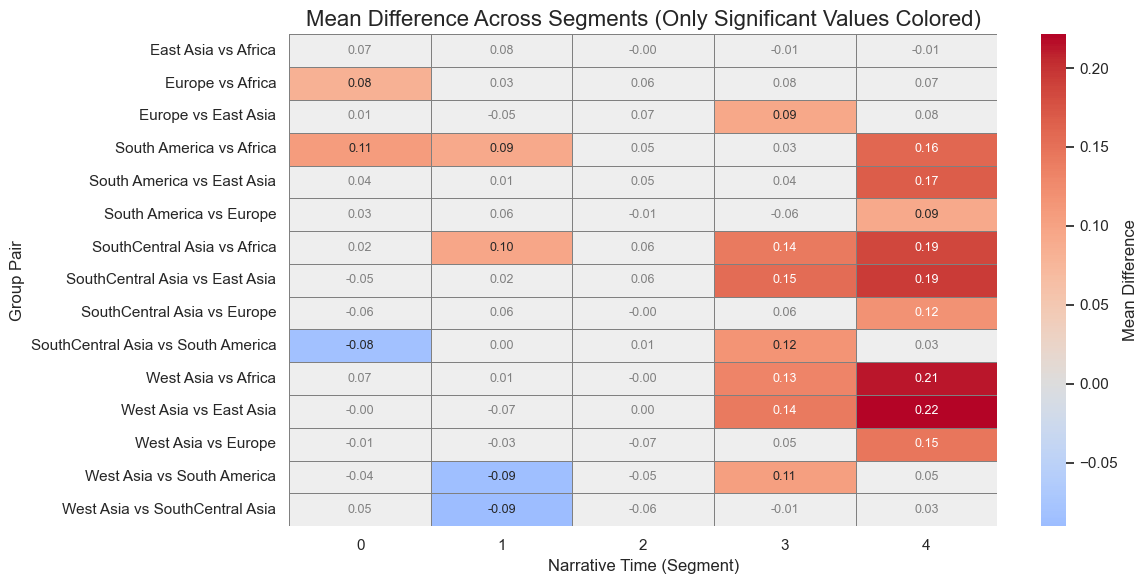

In [45]:
df = pd.read_csv("2Tukey_HSD_Results_Across_Segments.csv")

df["Group Pair"] = df["group2"] + " vs " + df["group1"]

pivot_means = df.pivot(index="Group Pair", columns="Segment", values="meandiff")
significance_mask = df.pivot(index="Group Pair", columns="Segment", values="reject")

color_mask = significance_mask != True

plt.figure(figsize=(12, max(6, len(pivot_means) * 0.4)))

sns.heatmap(pivot_means, annot=pivot_means, fmt=".2f",
            cmap="coolwarm", center=0,
            mask=color_mask,
            linewidths=.5, linecolor='gray',
            cbar_kws={"label": "Mean Difference"},
            annot_kws={"fontsize": 9})

sns.heatmap(pivot_means, annot=pivot_means, fmt=".2f",
            cmap=sns.color_palette(["#eeeeee"]),
            mask=~color_mask,
            cbar=False,
            annot_kws={"fontsize": 9, "color": "gray"},
            linewidths=.5, linecolor='gray')

plt.title("Mean Difference Across Segments (Only Significant Values Colored)", fontsize=16)
plt.xlabel("Narrative Time (Segment)", fontsize=12)
plt.ylabel("Group Pair", fontsize=12)

plt.tight_layout()
plt.show()